The Notebook should be run from the top to bottom. Block 2 is the data processing part in section 3.2, block 3 is the starter file code (section 3.3). Block 4 contains the model set up and training function for CNN in section 5, while block 5 is the main function to actual process the data to dataloders, batch size hyperparameter should be set up here. Block 6 corrospondes to section 5.1, block 7 corrospondes to section 5.2.1, different hyperparameters could be passed into the call to the training function to tune the model. Block 8 corrospondes to section 5.2.2, where Freezing is set up to False. The last few blocks corrospondes to section 5.3.\
When there's a need to change batch size, rerun block 5 with appropriate batch size. Other parameters can be tuned when calling the training function in block 6, 7 and 8.

In [ ]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn, optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
# Read TSV file into DataFrame
df = pd.read_csv('data/data.tsv', sep='\t')
data_list = df.values.tolist()
text_list = df["text"].tolist()
label_list = df["label"].tolist()
#ensure balanced class using stratify parameter
X_train, X_val_test, y_train, y_val_test = train_test_split(text_list, label_list, test_size=0.36, stratify = label_list, random_state=6)
print(y_train.count(0), y_train.count(1)) # 3200, 3200
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=(20/36), stratify = y_val_test, random_state=6)
print(y_val.count(0), y_val.count(1)) # 800, 800
print(y_test.count(0), y_test.count(1)) # 1000, 1000
print(len(X_train), len(X_val), len(X_test)) # 6400, 1600, 2000
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
train_df.to_csv('data/train.tsv', sep='\t', index=False)
validation_df = pd.DataFrame({'text': X_val, 'label': y_val})
validation_df.to_csv('data/validation.tsv', sep='\t', index=False)
test_df = pd.DataFrame({'text': X_test, 'label': y_test})
test_df.to_csv('data/test.tsv', sep='\t', index=False)

X_overfit, X_other, y_overfit, y_other = train_test_split(text_list, label_list, test_size=0.995, stratify = label_list, random_state=6)
print(len(X_overfit), y_overfit.count(0), y_overfit.count(1)) # 50 25 25
overfit_df = pd.DataFrame({'text': X_overfit, 'label': y_overfit})
overfit_df.to_csv('data/overfit.tsv', sep='\t', index=False)

3200 3200
800 800
1000 1000
6400 1600 2000
50 25 25


In [ ]:
# TextDataset is Described in Section 3.3 of Assignment 2

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device),
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    # Change made here, to make the X_batch of size (batch_size, word_indicies_len)
    #return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)
    return torch.stack(batch_x).int().to(device), torch.tensor(batch_y).to(device)

In [113]:
class CNNModel(torch.nn.Module):
    def __init__(self, vocab, k1, k2, n1, n2, freeze=True):
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(vocab.vectors, freeze=freeze)
        embedding_size = len(vocab.vectors[0])
        # 1st convolution layer  parameters(in_kernels, out_feature_maps, kernel_size)
        # 1 input matrix, n1 output feature maps (there are n1 kernels)
        self.conv_1 = nn.Conv2d(1, n1, (k1, embedding_size), bias=False)
        # 2nd convolution layer
        self.conv_2 = nn.Conv2d(1, n2, (k2, embedding_size), bias=False)
        # final linear layer
        self.linear = nn.Linear(n1 + n2, 1)

    def forward(self, x):
        # x shape: (batch_size, sentence_len/word_indices_len(N))

        # nn.Conv2d's input tensor should have the shape (batch_size, num_in_kernals, height_in, width_in)
        # nn.Conv2d's input tensor should have the shape
        # (batch_size, num_out_feature_maps, height_feature_map, width_feature_map)

        # embedding shape: (batch_size, N, embedding_size)
        # after squeeze: (batch_size, 1, N, embedding_size)
        x = self.embedding(x).unsqueeze(1)
        # apply activation function after two convolutional layer
        x1 = F.relu(self.conv_1(x)) # output shape: (batch_size, n1, N-k1+1, 1)
        x2 = F.relu(self.conv_2(x)) # output shape: (batch_size, n2, N-k2+1, 1)
        # apply maxpool over the output feature maps, over the N-k1/k2+1 values
        pool_1 = nn.MaxPool1d(x1.shape[2])
        pool_2 = nn.MaxPool1d(x2.shape[2])
        # maxpool input: (batch_size, num_of_channels, sequence_length)
        output_1 = pool_1(x1.squeeze(-1)).squeeze(-1) # output shape: (batch_size, n1)
        output_2 = pool_2(x2.squeeze(-1)).squeeze(-1) # output shape: (batch_size, n2)
        output = torch.cat((output_1, output_2), dim=1) # output shape: (batch_size, n1+n2)
        prediction = self.linear(output)
        return prediction

# same training function as baseline model
def train_CNN(vocab, train_dataloader, validation_dataloader, device, k1, k2, n1, n2, num_epochs=50, lr=0.001, freeze=True):
  num_epochs = num_epochs
  lr = lr

  # instantiate the model & set up the optimizer
  model = CNNModel(vocab, k1, k2, n1, n2, freeze)
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  # loss function
  criterion = nn.BCEWithLogitsLoss()

  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []
  max_val_accuracy = 0
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct_labels = 0.0
    num_training_examples = 0

    for word_indicies, labels in train_dataloader:
      #print("word_indicies", word_indicies)
      #print("labels", labels)
      optimizer.zero_grad()
      predictions = model.forward(word_indicies)
      predictions = predictions.to(torch.float32).squeeze()
      labels = labels.to(torch.float32)
      loss = criterion(predictions, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      # also need to calculate the accuracy
      # > 0.5 -> label 1 and <= 0.5 -> label 0
      predictions = torch.round(torch.sigmoid(predictions))
      num_training_examples += len(predictions)
      num_correct_labels = (predictions == labels).sum().item()
      train_correct_labels += num_correct_labels
    train_losses.append(train_loss / len(train_dataloader))
    train_accuracies.append(train_correct_labels / num_training_examples)

    model.eval()
    val_loss = 0.0
    val_correct_labels = 0.0
    num_validation_examples = 0
    with torch.no_grad():
      for word_indicies, labels in validation_dataloader:
        predictions = model.forward(word_indicies)
        predictions = predictions.to(torch.float32).squeeze()
        labels = labels.to(torch.float32)
        loss = criterion(predictions, labels)
        val_loss += loss.item()
        predictions = torch.round(torch.sigmoid(predictions))
        num_validation_examples += len(predictions)
        num_correct_labels = (predictions == labels).sum().item()
        val_correct_labels += num_correct_labels
    val_losses.append(val_loss / len(validation_dataloader))
    val_accuracies.append(val_correct_labels / num_validation_examples)

    # save model in pt file
    if (val_accuracies[-1] > max_val_accuracy):
      max_val_accuracy = val_accuracies[-1]
      torch.save(model.state_dict(), 'model_cnn.pt')

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}" )
  return model, train_losses, val_losses, train_accuracies, val_accuracies

In [44]:
def main(batch_size):
  #   fix seed
  torch.manual_seed(2)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print ("Using device:", device)

  ### 3.3 Processing of the data ###
  # 3.3.1
  # The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
  glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100

  # 3.3.2

  train_dataset = TextDataset(glove, "train")
  val_dataset = TextDataset(glove, "validation")
  test_dataset = TextDataset(glove, "test")
  overfit_dataset = TextDataset(glove, "overfit")

  # 3.3.3
  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=batch_size,
      shuffle=False,
      collate_fn=lambda batch: my_collate_function(batch, device))

  validation_dataloader = torch.utils.data.DataLoader(
      dataset=val_dataset,
      batch_size=batch_size,
      shuffle=False,
      collate_fn=lambda batch: my_collate_function(batch, device))

  test_dataloader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=batch_size,
      shuffle=False,
      collate_fn=lambda batch: my_collate_function(batch, device))

  overfit_dataloader = torch.utils.data.DataLoader(
      dataset=overfit_dataset,
      batch_size=batch_size,
      shuffle=False,
      collate_fn=lambda batch: my_collate_function(batch, device))

  return glove, train_dataloader, validation_dataloader, test_dataloader, overfit_dataloader, device

  # Instantiate your model(s) and train them and so on
  # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
  # so that it is easier to experiment with
batch_size = 16
glove, train_dataloader, validation_dataloader, test_dataloader, overfit_dataloader, device = main(batch_size)

Using device: cuda


Epoch [1/30] - Train Loss: 0.6906, Train Accuracy: 0.5000, Validation Loss: 0.6639, Validation Accuracy: 0.6456
Epoch [2/30] - Train Loss: 0.5643, Train Accuracy: 0.9800, Validation Loss: 0.6478, Validation Accuracy: 0.6306
Epoch [3/30] - Train Loss: 0.5118, Train Accuracy: 1.0000, Validation Loss: 0.6287, Validation Accuracy: 0.8294
Epoch [4/30] - Train Loss: 0.4457, Train Accuracy: 1.0000, Validation Loss: 0.6112, Validation Accuracy: 0.8494
Epoch [5/30] - Train Loss: 0.3866, Train Accuracy: 1.0000, Validation Loss: 0.5923, Validation Accuracy: 0.8588
Epoch [6/30] - Train Loss: 0.3308, Train Accuracy: 1.0000, Validation Loss: 0.5722, Validation Accuracy: 0.8550
Epoch [7/30] - Train Loss: 0.2781, Train Accuracy: 1.0000, Validation Loss: 0.5526, Validation Accuracy: 0.8550
Epoch [8/30] - Train Loss: 0.2299, Train Accuracy: 1.0000, Validation Loss: 0.5334, Validation Accuracy: 0.8538
Epoch [9/30] - Train Loss: 0.1890, Train Accuracy: 1.0000, Validation Loss: 0.5157, Validation Accuracy:

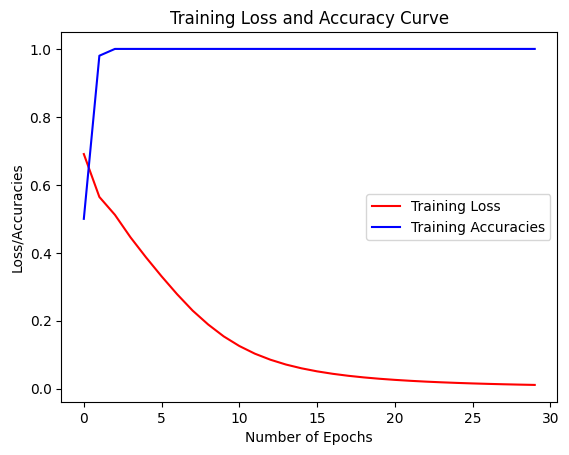

In [ ]:
# section 5.1
model, train_losses, val_losses, train_accuracies, val_accuracies = train_CNN(glove, overfit_dataloader, validation_dataloader, device, k1 = 2, k2 = 4, n1 = 50, n2 = 20, lr = 0.001, num_epochs=30)

fig, ax = plt.subplots()

# Plot training and validation losses
ax.plot(train_losses, 'r', label='Training Loss')
ax.plot(train_accuracies, 'b', label='Training Accuracies')

# Set labels and legend
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Loss/Accuracies')
ax.set_title('Training Loss and Accuracy Curve')
ax.legend()

# Show the plot
plt.show()

Epoch [1/50] - Train Loss: 0.5645, Train Accuracy: 0.8034, Validation Loss: 0.4326, Validation Accuracy: 0.8775
Epoch [2/50] - Train Loss: 0.3664, Train Accuracy: 0.8830, Validation Loss: 0.3188, Validation Accuracy: 0.8862
Epoch [3/50] - Train Loss: 0.2946, Train Accuracy: 0.8930, Validation Loss: 0.2837, Validation Accuracy: 0.8912
Epoch [4/50] - Train Loss: 0.2622, Train Accuracy: 0.8992, Validation Loss: 0.2665, Validation Accuracy: 0.8956
Epoch [5/50] - Train Loss: 0.2408, Train Accuracy: 0.9070, Validation Loss: 0.2554, Validation Accuracy: 0.8969
Epoch [6/50] - Train Loss: 0.2241, Train Accuracy: 0.9148, Validation Loss: 0.2472, Validation Accuracy: 0.8981
Epoch [7/50] - Train Loss: 0.2100, Train Accuracy: 0.9206, Validation Loss: 0.2405, Validation Accuracy: 0.8994
Epoch [8/50] - Train Loss: 0.1976, Train Accuracy: 0.9259, Validation Loss: 0.2350, Validation Accuracy: 0.9019
Epoch [9/50] - Train Loss: 0.1864, Train Accuracy: 0.9306, Validation Loss: 0.2303, Validation Accuracy:

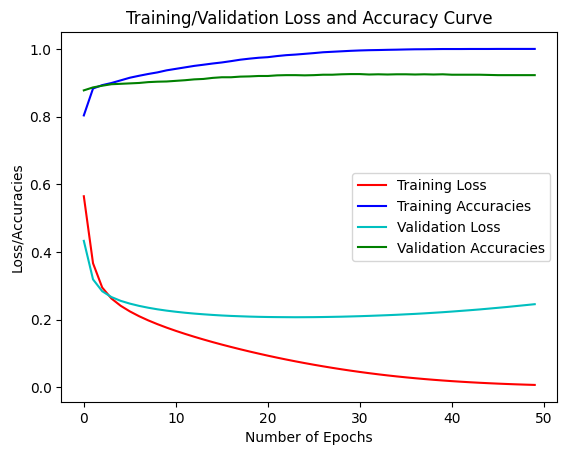

In [110]:

# section 5.2.1
model, train_losses, val_losses, train_accuracies, val_accuracies = train_CNN(glove, train_dataloader, validation_dataloader, device, k1 = 2, k2 = 4, n1 = 100, n2 = 100, lr = 0.0001, num_epochs=50)


#Test accuracy
def compute_test_accuracy(model):
  model.eval()
  test_correct_labels = 0
  num_test_examples = 0
  with torch.no_grad():
    for word_indicies, labels in test_dataloader:
      predictions = model.forward(word_indicies).squeeze()
      predictions = torch.round(torch.sigmoid(predictions))
      num_test_examples += len(predictions)
      num_correct_labels = (predictions == labels).sum().item()
      test_correct_labels += num_correct_labels
  test_accuracy = test_correct_labels / num_test_examples
  print("Final Test Accuracy is", test_accuracy)
compute_test_accuracy(model)

fig, ax = plt.subplots()

# Plot training and validation losses
ax.plot(train_losses, 'r', label='Training Loss')
ax.plot(train_accuracies, 'b', label='Training Accuracies')
ax.plot(val_losses, 'c', label='Validation Loss')
ax.plot(val_accuracies, 'g', label='Validation Accuracies')

# Set labels and legend
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Loss/Accuracies')
ax.set_title('Training/Validation Loss and Accuracy Curve')
ax.legend()

# Show the plot
plt.show()

Epoch [1/50] - Train Loss: 0.5553, Train Accuracy: 0.8128, Validation Loss: 0.4231, Validation Accuracy: 0.8794
Epoch [2/50] - Train Loss: 0.3498, Train Accuracy: 0.8864, Validation Loss: 0.3074, Validation Accuracy: 0.8900
Epoch [3/50] - Train Loss: 0.2721, Train Accuracy: 0.9016, Validation Loss: 0.2704, Validation Accuracy: 0.8950
Epoch [4/50] - Train Loss: 0.2324, Train Accuracy: 0.9133, Validation Loss: 0.2509, Validation Accuracy: 0.9000
Epoch [5/50] - Train Loss: 0.2040, Train Accuracy: 0.9248, Validation Loss: 0.2379, Validation Accuracy: 0.9050
Epoch [6/50] - Train Loss: 0.1810, Train Accuracy: 0.9345, Validation Loss: 0.2282, Validation Accuracy: 0.9087
Epoch [7/50] - Train Loss: 0.1614, Train Accuracy: 0.9434, Validation Loss: 0.2207, Validation Accuracy: 0.9131
Epoch [8/50] - Train Loss: 0.1441, Train Accuracy: 0.9514, Validation Loss: 0.2147, Validation Accuracy: 0.9175
Epoch [9/50] - Train Loss: 0.1285, Train Accuracy: 0.9591, Validation Loss: 0.2100, Validation Accuracy:

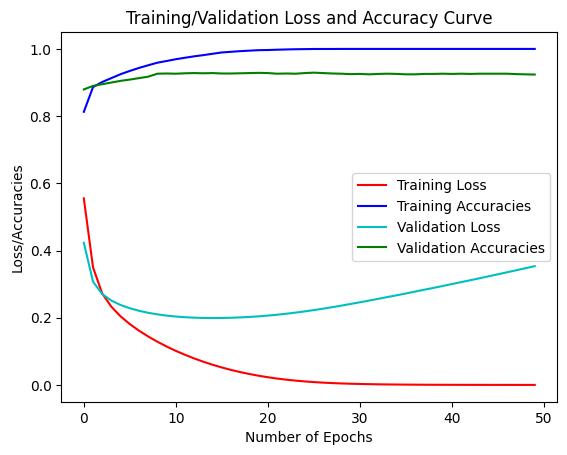

In [114]:
# section 5.2.2
# set freeze = False
model, train_losses, val_losses, train_accuracies, val_accuracies = train_CNN(glove, train_dataloader, validation_dataloader, device, k1 = 2, k2 = 4, n1 = 100, n2 = 100, lr = 0.0001, num_epochs=50, freeze=False)

def compute_test_accuracy(model):
  model.eval()
  test_correct_labels = 0
  num_test_examples = 0
  with torch.no_grad():
    for word_indicies, labels in test_dataloader:
      predictions = model.forward(word_indicies).squeeze()
      predictions = torch.round(torch.sigmoid(predictions))
      num_test_examples += len(predictions)
      num_correct_labels = (predictions == labels).sum().item()
      test_correct_labels += num_correct_labels
  test_accuracy = test_correct_labels / num_test_examples
  print("Final Test Accuracy is", test_accuracy)
#Test accuracy
compute_test_accuracy(model)

fig, ax = plt.subplots()

# Plot training and validation losses
ax.plot(train_losses, 'r', label='Training Loss')
ax.plot(train_accuracies, 'b', label='Training Accuracies')
ax.plot(val_losses, 'c', label='Validation Loss')
ax.plot(val_accuracies, 'g', label='Validation Accuracies')

# Set labels and legend
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Loss/Accuracies')
ax.set_title('Training/Validation Loss and Accuracy Curve')
ax.legend()

# Show the plot
plt.show()

In [124]:
def print_closest_cosine_words(vec, n=5):
    similarities = torch.cosine_similarity(glove.vectors, vec.unsqueeze(0))   # compute similarities to all words
    lst = sorted(enumerate(similarities.numpy()), key=lambda x: x[1], reverse=True) # sort by similarities in descending order
    for idx, similarity in lst[0:n]:  # take the top n
        print(glove.itos[idx], "\t%5.2f" % similarity)

In [188]:
#load the checkpoint
checkpoint = torch.load('model_cnn.pt')
cnn_model = CNNModel(glove, k1=2, k2=4, n1=100, n2=100)
cnn_model.load_state_dict(checkpoint)

import random
random.seed(33)
model_parameters = list(model.parameters())
# weight tensor shape: (out_channels, in_channels, kernel_height, kernel_width)
# (n1/n2, 1, k1/k2, embedding_size)
conv_1_weights = model_parameters[1].squeeze(1) #2*100 words
conv_2_weights = model_parameters[2].squeeze(1) #4*100 words shape(100,4,100)

# randomly choose 5 word embedding from each layer weights, and print 5 cloeset words
j = random.sample(range(100), 5)
for i in range(5):
  k = random.randint(0, 1)
  print("conv_1 weights, the ", k+1, " kernel in k1 (size=2)")
  print_closest_cosine_words(conv_1_weights[j[i]][k].detach().cpu())
  print("-----------------------------------------------")

j = random.sample(range(100), 5)
for i in range(5):
  y = random.randint(0, 3)
  print("conv_2 weights, the ", y+1, " kernel in k2 (size=4)")
  print_closest_cosine_words(conv_2_weights[j[i]][y].detach().cpu())
  print("-----------------------------------------------")


conv_1 weights, the  2  kernel in k1 (size=2)
magog 	 0.46
gwynns 	 0.43
discomforts 	 0.40
pitfalls 	 0.40
gog 	 0.40
-----------------------------------------------
conv_1 weights, the  1  kernel in k1 (size=2)
para-alpine 	 0.45
merrier 	 0.42
wasnt 	 0.42
livelier 	 0.42
daresay 	 0.42
-----------------------------------------------
conv_1 weights, the  2  kernel in k1 (size=2)
bataan 	 0.42
mochovce 	 0.42
zaporizhia 	 0.41
retake 	 0.40
gangwon 	 0.40
-----------------------------------------------
conv_1 weights, the  2  kernel in k1 (size=2)
kakavand 	 0.42
danneels 	 0.39
arsonists 	 0.39
nitrofuran 	 0.39
ichihashi 	 0.38
-----------------------------------------------
conv_1 weights, the  2  kernel in k1 (size=2)
north-westerly 	 0.50
soporific 	 0.50
55.14 	 0.49
cost-efficient 	 0.49
84.32 	 0.48
-----------------------------------------------
conv_2 weights, the  4  kernel in k2 (size=4)
brazen 	 0.43
ferocious 	 0.42
1-meter 	 0.41
185 	 0.41
216 	 0.41
-----------------